In [1]:
import os, sys, time, glob, random, argparse
import numpy as np
from copy import deepcopy
import torch
import torch.nn as nn

# XAutoDL 
from xautodl.config_utils import load_config, dict2config, configure2str
from xautodl.datasets import get_datasets, get_nas_search_loaders
from xautodl.procedures import (
    prepare_seed,
    prepare_logger,
    save_checkpoint,
    copy_checkpoint,
    get_optim_scheduler,
)
from xautodl.utils import get_model_infos, obtain_accuracy
from xautodl.log_utils import AverageMeter, time_string, convert_secs2time
from xautodl.models import get_cell_based_tiny_net, get_search_spaces

# NB201
from nas_201_api import NASBench201API as API

import tqdm

2022-10-20 03:46:06.114288: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
parser = argparse.ArgumentParser("Random search for NAS.")
parser.add_argument("--data_path", type=str, default='../cifar.python', help="The path to dataset")
parser.add_argument("--dataset", type=str, default='cifar10',choices=["cifar10", "cifar100", "ImageNet16-120"], help="Choose between Cifar10/100 and ImageNet-16.")

# channels and number-of-cells
parser.add_argument("--search_space_name", type=str, default='nas-bench-201', help="The search space name.")
parser.add_argument("--config_path", type=str, default='./MY.config', help="The path to the configuration.")
# parser.add_argument("--config_path", type=str, default='./MY.config', help="The path to the configuration.")
parser.add_argument("--max_nodes", type=int, default=4, help="The maximum number of nodes.")
parser.add_argument("--channel", type=int, default=16, help="The number of channels.")
parser.add_argument("--num_cells", type=int, default=5, help="The number of cells in one stage.")
parser.add_argument("--select_num", type=int, default=100, help="The number of selected architectures to evaluate.")
parser.add_argument("--track_running_stats", type=int, default=0, choices=[0, 1], help="Whether use track_running_stats or not in the BN layer.")
# log
parser.add_argument("--workers", type=int, default=4, help="number of data loading workers")
parser.add_argument("--save_dir", type=str, default='../results/three_metrics_reduce_ep/25ep_cosine', help="Folder to save checkpoints and log.")
parser.add_argument("--arch_nas_dataset", type=str, default='../NAS-Bench-201-v1_1-096897.pth', help="The path to load the architecture dataset (tiny-nas-benchmark).")
parser.add_argument("--print_freq", type=int, default=200, help="print frequency (default: 200)")
parser.add_argument("--rand_seed", type=int, default=None, help="manual seed")
args = parser.parse_args(args=[])
if args.rand_seed is None or args.rand_seed < 0:
    args.rand_seed = random.randint(1, 100000)

print(args.rand_seed)
print(args)
xargs=args

96974
Namespace(arch_nas_dataset='../NAS-Bench-201-v1_1-096897.pth', channel=16, config_path='./MY.config', data_path='../cifar.python', dataset='cifar10', max_nodes=4, num_cells=5, print_freq=200, rand_seed=96974, save_dir='../results/three_metrics_reduce_ep/25ep_cosine', search_space_name='nas-bench-201', select_num=100, track_running_stats=0, workers=4)


In [3]:
assert torch.cuda.is_available(), "CUDA is not available."
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.set_num_threads(xargs.workers)
prepare_seed(xargs.rand_seed)
logger = prepare_logger(args)

Main Function with logger : Logger(dir=../results/three_metrics_reduce_ep/25ep_cosine, use-tf=False, writer=None)
Arguments : -------------------------------
arch_nas_dataset : ../NAS-Bench-201-v1_1-096897.pth
channel          : 16
config_path      : ./MY.config
data_path        : ../cifar.python
dataset          : cifar10
max_nodes        : 4
num_cells        : 5
print_freq       : 200
rand_seed        : 96974
save_dir         : ../results/three_metrics_reduce_ep/25ep_cosine
search_space_name : nas-bench-201
select_num       : 100
track_running_stats : 0
workers          : 4
Python  Version  : 3.7.13 (default, Mar 29 2022, 02:18:16)  [GCC 7.5.0]
Pillow  Version  : 9.0.1
PyTorch Version  : 1.12.0
cuDNN   Version  : 8302
CUDA available   : True
CUDA GPU numbers : 2
CUDA_VISIBLE_DEVICES : None


In [4]:
def search_func(xloader, network, criterion, scheduler, w_optimizer, epoch_str, print_freq, logger):
    data_time, batch_time = AverageMeter(), AverageMeter()
    base_losses, base_top1, base_top5 = AverageMeter(), AverageMeter(), AverageMeter()
    network.train()
    end = time.time()
    for step, (base_inputs, base_targets, arch_inputs, arch_targets) in enumerate(
        xloader
    ):
        scheduler.update(None, 1.0 * step / len(xloader))
        base_targets = base_targets.cuda(non_blocking=True)
        arch_targets = arch_targets.cuda(non_blocking=True)
        # measure data loading time
        data_time.update(time.time() - end)

        # update the weights
        network.module.random_genotype(True)
        w_optimizer.zero_grad()
        _, logits = network(base_inputs)
        base_loss = criterion(logits, base_targets)
        base_loss.backward()
        nn.utils.clip_grad_norm_(network.parameters(), 5)
        w_optimizer.step()
        # record
        base_prec1, base_prec5 = obtain_accuracy(
            logits.data, base_targets.data, topk=(1, 5)
        )
        base_losses.update(base_loss.item(), base_inputs.size(0))
        base_top1.update(base_prec1.item(), base_inputs.size(0))
        base_top5.update(base_prec5.item(), base_inputs.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if step % print_freq == 0 or step + 1 == len(xloader):
            Sstr = (
                "*SEARCH* "
                + time_string()
                + " [{:}][{:03d}/{:03d}]".format(epoch_str, step, len(xloader))
            )
            Tstr = "Time {batch_time.val:.2f} ({batch_time.avg:.2f}) Data {data_time.val:.2f} ({data_time.avg:.2f})".format(
                batch_time=batch_time, data_time=data_time
            )
            Wstr = "Base [Loss {loss.val:.3f} ({loss.avg:.3f})  Prec@1 {top1.val:.2f} ({top1.avg:.2f}) Prec@5 {top5.val:.2f} ({top5.avg:.2f})]".format(
                loss=base_losses, top1=base_top1, top5=base_top5
            )
            logger.log(Sstr + " " + Tstr + " " + Wstr)
    return base_losses.avg, base_top1.avg, base_top5.avg


def valid_func(xloader, network, criterion):
    data_time, batch_time = AverageMeter(), AverageMeter()
    arch_losses, arch_top1, arch_top5 = AverageMeter(), AverageMeter(), AverageMeter()
    network.eval()
    end = time.time()
    with torch.no_grad():
        for step, (arch_inputs, arch_targets) in enumerate(xloader):
            arch_targets = arch_targets.cuda(non_blocking=True)
            # measure data loading time
            data_time.update(time.time() - end)
            # prediction

            network.module.random_genotype(True)
            _, logits = network(arch_inputs)
            arch_loss = criterion(logits, arch_targets)
            # record
            arch_prec1, arch_prec5 = obtain_accuracy(
                logits.data, arch_targets.data, topk=(1, 5)
            )
            arch_losses.update(arch_loss.item(), arch_inputs.size(0))
            arch_top1.update(arch_prec1.item(), arch_inputs.size(0))
            arch_top5.update(arch_prec5.item(), arch_inputs.size(0))
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
    return arch_losses.avg, arch_top1.avg, arch_top5.avg


def search_find_best(xloader, network, n_samples):
    with torch.no_grad():
        network.eval()
        archs, valid_accs = [], []
        # print ('obtain the top-{:} architectures'.format(n_samples))
        loader_iter = iter(xloader)
        for i in range(n_samples):
            arch = network.module.random_genotype(True)
            try:
                inputs, targets = next(loader_iter)
            except:
                loader_iter = iter(xloader)
                inputs, targets = next(loader_iter)

            _, logits = network(inputs)
            val_top1, val_top5 = obtain_accuracy(
                logits.cpu().data, targets.data, topk=(1, 5)
            )

            archs.append(arch)
            valid_accs.append(val_top1.item())

        best_idx = np.argmax(valid_accs)
        best_arch, best_valid_acc = archs[best_idx], valid_accs[best_idx]
        return best_arch, best_valid_acc
    

# Main

In [5]:
train_data, valid_data, xshape, class_num = get_datasets(xargs.dataset, xargs.data_path, -1)
config = load_config(xargs.config_path, {"class_num": class_num, "xshape": xshape}, logger)
search_loader, _, valid_loader = get_nas_search_loaders(train_data,
                                                        valid_data,
                                                        xargs.dataset,
                                                        "../configs/nas-benchmark/",
                                                        (config.batch_size, config.test_batch_size),
                                                        xargs.workers)
logger.log("||||||| {:10s} ||||||| Search-Loader-Num={:}, Valid-Loader-Num={:}, batch size={:}".format(
            xargs.dataset, len(search_loader), len(valid_loader), config.batch_size))
logger.log("||||||| {:10s} ||||||| Config={:}".format(xargs.dataset, config))

search_space = get_search_spaces("cell", xargs.search_space_name)
model_config = dict2config(
    {
        "name": "RANDOM",
        "C": xargs.channel,
        "N": xargs.num_cells,
        "max_nodes": xargs.max_nodes,
        "num_classes": class_num,
        "space": search_space,
        "affine": False,
        "track_running_stats": bool(xargs.track_running_stats),
    },
    None,
)
search_model = get_cell_based_tiny_net(model_config)

w_optimizer, w_scheduler, criterion = get_optim_scheduler(search_model.parameters(), config)

logger.log("w-optimizer : {:}".format(w_optimizer))
logger.log("w-scheduler : {:}".format(w_scheduler))
logger.log("criterion   : {:}".format(criterion))
if xargs.arch_nas_dataset is None:
    api = None
else:
    api = API(xargs.arch_nas_dataset)
logger.log("{:} create API = {:} done".format(time_string(), api))

last_info, model_base_path, model_best_path = (
    logger.path("info"),
    logger.path("model"),
    logger.path("best"),
)
network, criterion = torch.nn.DataParallel(search_model).cuda(), criterion.cuda()

Files already downloaded and verified
Files already downloaded and verified
./MY.config
Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=25, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))
||||||| cifar10    ||||||| Search-Loader-Num=391, Valid-Loader-Num=49, batch size=64
||||||| cifar10    ||||||| Config=Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=25, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))
w-optimizer : SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    initial_lr: 0.025
    lr: 0.025
    maximize: False
    momentum: 0.9
    nesterov: True
    weight_decay: 0.0005
)
w-scheduler : CosineAnnealingLR(warmup=0, max-epoch=25, current::epoch=0, iter=0.00, type=cosine, T-max=25, eta-min=0.001)
criterion   : CrossEntropyLoss(

In [6]:
if last_info.exists():  # automatically resume from previous checkpoint
    logger.log(
        "=> loading checkpoint of the last-info '{:}' start".format(last_info)
    )
    last_info = torch.load(last_info)
    start_epoch = last_info["epoch"]
    checkpoint = torch.load(last_info["last_checkpoint"])
    genotypes = checkpoint["genotypes"]
    valid_accuracies = checkpoint["valid_accuracies"]
    search_model.load_state_dict(checkpoint["search_model"])
    w_scheduler.load_state_dict(checkpoint["w_scheduler"])
    w_optimizer.load_state_dict(checkpoint["w_optimizer"])
    logger.log(
        "=> loading checkpoint of the last-info '{:}' start with {:}-th epoch.".format(
            last_info, start_epoch
        )
    )
else:
    logger.log("=> do not find the last-info file : {:}".format(last_info))
    start_epoch, valid_accuracies, genotypes = 0, {"best": -1}, {}

# start training
start_time, search_time, epoch_time, total_epoch = (
    time.time(),
    AverageMeter(),
    AverageMeter(),
    config.epochs + config.warmup,
)
for epoch in range(start_epoch, total_epoch):
    w_scheduler.update(epoch, 0.0)
    need_time = "Time Left: {:}".format(
        convert_secs2time(epoch_time.val * (total_epoch - epoch), True)
    )
    epoch_str = "{:03d}-{:03d}".format(epoch, total_epoch)
    logger.log(
        "\n[Search the {:}-th epoch] {:}, LR={:}".format(
            epoch_str, need_time, min(w_scheduler.get_lr())
        )
    )

    # selected_arch = search_find_best(valid_loader, network, criterion, xargs.select_num)
    search_w_loss, search_w_top1, search_w_top5 = search_func(
        search_loader,
        network,
        criterion,
        w_scheduler,
        w_optimizer,
        epoch_str,
        xargs.print_freq,
        logger,
    )
    search_time.update(time.time() - start_time)
    logger.log(
        "[{:}] searching : loss={:.2f}, accuracy@1={:.2f}%, accuracy@5={:.2f}%, time-cost={:.1f} s".format(
            epoch_str, search_w_loss, search_w_top1, search_w_top5, search_time.sum
        )
    )
    valid_a_loss, valid_a_top1, valid_a_top5 = valid_func(
        valid_loader, network, criterion
    )
    logger.log(
        "[{:}] evaluate  : loss={:.2f}, accuracy@1={:.2f}%, accuracy@5={:.2f}%".format(
            epoch_str, valid_a_loss, valid_a_top1, valid_a_top5
        )
    )
    cur_arch, cur_valid_acc = search_find_best(
        valid_loader, network, xargs.select_num
    )
    logger.log(
        "[{:}] find-the-best : {:}, accuracy@1={:.2f}%".format(
            epoch_str, cur_arch, cur_valid_acc
        )
    )
    genotypes[epoch] = cur_arch
    # check the best accuracy
    valid_accuracies[epoch] = valid_a_top1
    if valid_a_top1 > valid_accuracies["best"]:
        valid_accuracies["best"] = valid_a_top1
        find_best = True
    else:
        find_best = False

    # save checkpoint
    save_path = save_checkpoint(
        {
            "epoch": epoch + 1,
            "args": deepcopy(xargs),
            "search_model": search_model.state_dict(),
            "w_optimizer": w_optimizer.state_dict(),
            "w_scheduler": w_scheduler.state_dict(),
            "genotypes": genotypes,
            "valid_accuracies": valid_accuracies,
        },
        model_base_path,
        logger,
    )
    last_info = save_checkpoint(
        {
            "epoch": epoch + 1,
            "args": deepcopy(args),
            "last_checkpoint": save_path,
        },
        logger.path("info"),
        logger,
    )
    if find_best:
        logger.log(
            "<<<--->>> The {:}-th epoch : find the highest validation accuracy : {:.2f}%.".format(
                epoch_str, valid_a_top1
            )
        )
        copy_checkpoint(model_base_path, model_best_path, logger)
    if api is not None:
        logger.log("{:}".format(api.query_by_arch(genotypes[epoch], "200")))
    # measure elapsed time
    epoch_time.update(time.time() - start_time)
    start_time = time.time()

logger.log("\n" + "-" * 200)
logger.log("Pre-searching costs {:.1f} s".format(search_time.sum))
start_time = time.time()
best_arch, best_acc = search_find_best(valid_loader, network, xargs.select_num)
search_time.update(time.time() - start_time)
logger.log(
    "RANDOM-NAS finds the best one : {:} with accuracy={:.2f}%, with {:.1f} s.".format(
        best_arch, best_acc, search_time.sum
    )
)
if api is not None:
    logger.log("{:}".format(api.query_by_arch(best_arch, "200")))
logger.close()

=> do not find the last-info file : ../results/three_metrics_reduce_ep/25ep_cosine/seed-96974-last-info.pth

[Search the 000-025-th epoch] Time Left: [00:00:00], LR=0.025
*SEARCH* [2022-10-20 03:47:00] [000-025][000/391] Time 3.63 (3.63) Data 1.29 (1.29) Base [Loss 2.322 (2.322)  Prec@1 17.19 (17.19) Prec@5 53.12 (53.12)]
*SEARCH* [2022-10-20 03:47:21] [000-025][200/391] Time 0.09 (0.12) Data 0.00 (0.01) Base [Loss 2.357 (2.251)  Prec@1 6.25 (13.98) Prec@5 40.62 (60.36)]
*SEARCH* [2022-10-20 03:47:41] [000-025][390/391] Time 0.07 (0.11) Data 0.00 (0.00) Base [Loss 2.010 (2.223)  Prec@1 35.00 (15.18) Prec@5 75.00 (63.24)]
[000-025] searching : loss=2.22, accuracy@1=15.18%, accuracy@5=63.24%, time-cost=44.4 s
[000-025] evaluate  : loss=2.18, accuracy@1=16.95%, accuracy@5=67.70%
[000-025] find-the-best : Structure(4 nodes with |avg_pool_3x3~0|+|skip_connect~0|nor_conv_1x1~1|+|nor_conv_3x3~0|skip_connect~1|none~2|), accuracy@1=24.02%
save checkpoint into ../results/three_metrics_reduce_ep/

*SEARCH* [2022-10-20 03:50:27] [003-025][000/391] Time 1.56 (1.56) Data 1.38 (1.38) Base [Loss 2.390 (2.390)  Prec@1 20.31 (20.31) Prec@5 59.38 (59.38)]
*SEARCH* [2022-10-20 03:50:57] [003-025][200/391] Time 0.12 (0.16) Data 0.00 (0.01) Base [Loss 2.127 (2.080)  Prec@1 25.00 (20.36) Prec@5 71.88 (74.20)]
*SEARCH* [2022-10-20 03:51:23] [003-025][390/391] Time 0.14 (0.15) Data 0.00 (0.00) Base [Loss 2.226 (2.075)  Prec@1 22.50 (21.08) Prec@5 67.50 (74.81)]
[003-025] searching : loss=2.08, accuracy@1=21.08%, accuracy@5=74.81%, time-cost=199.0 s
[003-025] evaluate  : loss=2.08, accuracy@1=20.89%, accuracy@5=74.41%
[003-025] find-the-best : Structure(4 nodes with |skip_connect~0|+|skip_connect~0|nor_conv_3x3~1|+|skip_connect~0|skip_connect~1|skip_connect~2|), accuracy@1=28.91%
Find ../results/three_metrics_reduce_ep/25ep_cosine/checkpoint/seed-96974-basic.pth exist, delete is at first before saving
save checkpoint into ../results/three_metrics_reduce_ep/25ep_cosine/checkpoint/seed-96974-bas

*SEARCH* [2022-10-20 03:54:37] [006-025][000/391] Time 1.42 (1.42) Data 1.32 (1.32) Base [Loss 2.170 (2.170)  Prec@1 7.81 (7.81) Prec@5 76.56 (76.56)]
*SEARCH* [2022-10-20 03:54:58] [006-025][200/391] Time 0.07 (0.11) Data 0.00 (0.01) Base [Loss 2.305 (2.031)  Prec@1 9.38 (22.61) Prec@5 46.88 (76.70)]
*SEARCH* [2022-10-20 03:55:19] [006-025][390/391] Time 0.12 (0.11) Data 0.00 (0.00) Base [Loss 2.198 (2.020)  Prec@1 20.00 (23.14) Prec@5 67.50 (77.77)]
[006-025] searching : loss=2.02, accuracy@1=23.14%, accuracy@5=77.77%, time-cost=360.8 s
[006-025] evaluate  : loss=2.03, accuracy@1=22.84%, accuracy@5=76.99%
[006-025] find-the-best : Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|skip_connect~0|none~1|nor_conv_3x3~2|), accuracy@1=32.62%
Find ../results/three_metrics_reduce_ep/25ep_cosine/checkpoint/seed-96974-basic.pth exist, delete is at first before saving
save checkpoint into ../results/three_metrics_reduce_ep/25ep_cosine/checkpoint/seed-96974-basic.pth
Find

*SEARCH* [2022-10-20 03:58:19] [009-025][000/391] Time 1.79 (1.79) Data 1.63 (1.63) Base [Loss 2.314 (2.314)  Prec@1 12.50 (12.50) Prec@5 48.44 (48.44)]
*SEARCH* [2022-10-20 03:58:53] [009-025][200/391] Time 0.14 (0.18) Data 0.00 (0.01) Base [Loss 1.950 (1.960)  Prec@1 23.44 (24.80) Prec@5 85.94 (80.19)]
*SEARCH* [2022-10-20 03:59:25] [009-025][390/391] Time 0.12 (0.17) Data 0.00 (0.00) Base [Loss 1.897 (1.952)  Prec@1 22.50 (25.50) Prec@5 85.00 (80.38)]
[009-025] searching : loss=1.95, accuracy@1=25.50%, accuracy@5=80.38%, time-cost=539.6 s
[009-025] evaluate  : loss=1.95, accuracy@1=24.91%, accuracy@5=81.20%
[009-025] find-the-best : Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|none~1|+|skip_connect~0|skip_connect~1|nor_conv_3x3~2|), accuracy@1=32.62%
Find ../results/three_metrics_reduce_ep/25ep_cosine/checkpoint/seed-96974-basic.pth exist, delete is at first before saving
save checkpoint into ../results/three_metrics_reduce_ep/25ep_cosine/checkpoint/seed-96974-basic.pth
F

*SEARCH* [2022-10-20 04:02:12] [012-025][000/391] Time 1.68 (1.68) Data 1.50 (1.50) Base [Loss 1.843 (1.843)  Prec@1 25.00 (25.00) Prec@5 82.81 (82.81)]
*SEARCH* [2022-10-20 04:02:48] [012-025][200/391] Time 0.14 (0.19) Data 0.00 (0.01) Base [Loss 2.320 (1.890)  Prec@1 9.38 (27.39) Prec@5 45.31 (82.27)]
*SEARCH* [2022-10-20 04:03:15] [012-025][390/391] Time 0.09 (0.17) Data 0.00 (0.00) Base [Loss 1.723 (1.891)  Prec@1 35.00 (27.62) Prec@5 90.00 (82.24)]
[012-025] searching : loss=1.89, accuracy@1=27.62%, accuracy@5=82.24%, time-cost=698.5 s
[012-025] evaluate  : loss=1.95, accuracy@1=24.93%, accuracy@5=80.15%
[012-025] find-the-best : Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_1x1~0|nor_conv_3x3~1|+|skip_connect~0|nor_conv_1x1~1|avg_pool_3x3~2|), accuracy@1=38.28%
Find ../results/three_metrics_reduce_ep/25ep_cosine/checkpoint/seed-96974-basic.pth exist, delete is at first before saving
save checkpoint into ../results/three_metrics_reduce_ep/25ep_cosine/checkpoint/seed-96974-basi

[015-025] searching : loss=1.85, accuracy@1=29.16%, accuracy@5=83.91%, time-cost=861.9 s
[015-025] evaluate  : loss=1.87, accuracy@1=28.37%, accuracy@5=82.83%
[015-025] find-the-best : Structure(4 nodes with |avg_pool_3x3~0|+|none~0|none~1|+|nor_conv_1x1~0|avg_pool_3x3~1|skip_connect~2|), accuracy@1=37.70%
Find ../results/three_metrics_reduce_ep/25ep_cosine/checkpoint/seed-96974-basic.pth exist, delete is at first before saving
save checkpoint into ../results/three_metrics_reduce_ep/25ep_cosine/checkpoint/seed-96974-basic.pth
Find ../results/three_metrics_reduce_ep/25ep_cosine/seed-96974-last-info.pth exist, delete is at first before saving
save checkpoint into ../results/three_metrics_reduce_ep/25ep_cosine/seed-96974-last-info.pth
<<<--->>> The 015-025-th epoch : find the highest validation accuracy : 28.37%.
Find ../results/three_metrics_reduce_ep/25ep_cosine/checkpoint/seed-96974-best.pth exist, delete is at first before saving
copy the file from ../results/three_metrics_reduce_ep/2

[018-025] evaluate  : loss=1.88, accuracy@1=27.60%, accuracy@5=83.55%
[018-025] find-the-best : Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_1x1~0|skip_connect~1|+|skip_connect~0|nor_conv_3x3~1|nor_conv_3x3~2|), accuracy@1=36.52%
Find ../results/three_metrics_reduce_ep/25ep_cosine/checkpoint/seed-96974-basic.pth exist, delete is at first before saving
save checkpoint into ../results/three_metrics_reduce_ep/25ep_cosine/checkpoint/seed-96974-basic.pth
Find ../results/three_metrics_reduce_ep/25ep_cosine/seed-96974-last-info.pth exist, delete is at first before saving
save checkpoint into ../results/three_metrics_reduce_ep/25ep_cosine/seed-96974-last-info.pth
Call query_info_str_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_1x1~0|skip_connect~1|+|skip_connect~0|nor_conv_3x3~1|nor_conv_3x3~2|) and hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_1x1~0|skip_connect~1|+|skip_connect~0|nor_conv_3x3~1|nor_conv_3x3~2|)
|nor_co

*SEARCH* [2022-10-20 04:14:58] [022-025][000/391] Time 1.46 (1.46) Data 1.35 (1.35) Base [Loss 1.404 (1.404)  Prec@1 53.12 (53.12) Prec@5 95.31 (95.31)]
*SEARCH* [2022-10-20 04:15:21] [022-025][200/391] Time 0.10 (0.12) Data 0.00 (0.01) Base [Loss 1.815 (1.787)  Prec@1 35.94 (31.26) Prec@5 84.38 (85.45)]
*SEARCH* [2022-10-20 04:15:43] [022-025][390/391] Time 0.08 (0.12) Data 0.00 (0.00) Base [Loss 1.920 (1.785)  Prec@1 27.50 (31.45) Prec@5 85.00 (85.33)]
[022-025] searching : loss=1.79, accuracy@1=31.45%, accuracy@5=85.33%, time-cost=1208.9 s
[022-025] evaluate  : loss=1.83, accuracy@1=29.76%, accuracy@5=84.37%
[022-025] find-the-best : Structure(4 nodes with |nor_conv_1x1~0|+|skip_connect~0|none~1|+|skip_connect~0|nor_conv_3x3~1|avg_pool_3x3~2|), accuracy@1=39.45%
Find ../results/three_metrics_reduce_ep/25ep_cosine/checkpoint/seed-96974-basic.pth exist, delete is at first before saving
save checkpoint into ../results/three_metrics_reduce_ep/25ep_cosine/checkpoint/seed-96974-basic.pth


In [8]:
# torch.save(network.state_dict(), "./25ep_cosine_supernet_weights.pth")

In [19]:
def valid_acc_metric(network, inputs, targets):
    with torch.no_grad():
        network.eval()
        _, logits = network(inputs)
        val_top1, val_top5 = obtain_accuracy(
            logits.data, targets.data, topk=(1, 5)
        )
    return val_top1.item()

def acc_confidence_robustness_metrics(network, inputs, targets):
    with torch.no_grad():
        network.eval()
        # accuracy
        _, logits = network(inputs)
        val_top1, val_top5 = obtain_accuracy(logits.data, targets.data, topk=(1, 5))
        acc = val_top1
        # confidence
        prob = torch.nn.functional.softmax(logits, dim=1)
        one_hot_idx = torch.nn.functional.one_hot(targets)
        confidence = (prob[one_hot_idx==1].sum()) / inputs.size(0) * 100 # in percent
        # robustness
        _, noisy_logits = network(inputs + torch.randn_like(inputs)*0.1)
        kl_loss = torch.nn.KLDivLoss(reduction="batchmean")
        robustness = -kl_loss(torch.nn.functional.log_softmax(noisy_logits, dim=1), torch.nn.functional.softmax(logits, dim=1))
        
        return acc.item(), confidence.item(), robustness.item()
    
def step_sim_metric(network, criterion, inputs, targets):
    original_dict = deepcopy(network.state_dict())
    optim_large_step = torch.optim.SGD(network.parameters(), lr=0.1)
    
    # single large step
    network.train()
    optim_large_step.zero_grad()
    _, logits = network(inputs)
    base_loss = criterion(logits, targets)
    base_loss.backward()
    optim_large_step.step()
    large_step_dict = deepcopy(network.state_dict())
    
    # multiple small steps
    network.load_state_dict(original_dict)
    optim_small_step = torch.optim.SGD(network.parameters(), lr=0.01)
    for i in range(10):
        optim_small_step.zero_grad()
        _, logits = network(inputs)
        base_loss = criterion(logits, targets)
        base_loss.backward()
        optim_small_step.step()
    small_step_dict = deepcopy(network.state_dict())
    
    # resume
    network.load_state_dict(original_dict)
    network.eval()
    
    for key in large_step_dict.keys():
#         if 'classifier' in key:
#             large_step = large_step_dict[key] - original_dict[key]
#             small_step = small_step_dict[key] - original_dict[key]
#             score = torch.nn.functional.cosine_similarity(large_step, small_step, dim=1)
#             score = score.mean().item() * 100 # in percent
#             break
        if 'stem.0.weight' in key:
            large_step = large_step_dict[key] - original_dict[key]
            small_step = small_step_dict[key] - original_dict[key]
            co, ci, kh, kw = large_step.size()
            large_step = large_step.view(co, -1)
            small_step = small_step.view(co, -1)
            score = torch.nn.functional.cosine_similarity(large_step, small_step, dim=1)
            score = score.mean().item() * 100 # in percent
            break
            
    return score
    

def search_find_best_my(xloader, network, criterion, n_samples):
    archs, metric_accs, metric_steps, metric_confidences, metric_robustnesses = [], [], [], [], []
    loader_iter = iter(xloader)
    for i in tqdm.tqdm(range(n_samples)):
        arch = network.module.random_genotype(True)
        try:
            inputs, targets = next(loader_iter)
        except:
            loader_iter = iter(xloader)
            inputs, targets = next(loader_iter)
        inputs, targets = inputs.cuda(non_blocking=True), targets.cuda(non_blocking=True)
#         valid_acc = valid_acc_metric(network, inputs, targets)
        valid_acc, confidence, robustness = acc_confidence_robustness_metrics(network, inputs, targets)
        step_sim = step_sim_metric(network, criterion, inputs, targets)

        archs.append(arch)
        metric_accs.append(valid_acc)
        metric_steps.append(step_sim)
        metric_confidences.append(confidence)
        metric_robustnesses.append(robustness)

    return archs, metric_accs, metric_steps, metric_confidences, metric_robustnesses

    
archs, metric_accs, metric_steps, metric_confidences, metric_robustnesses = search_find_best_my(valid_loader, network, criterion, 250)

100%|██████████| 1000/1000 [04:25<00:00,  3.76it/s]


In [20]:
import scipy.stats as stats
rank_accs, rank_steps, rank_confidences, rank_robustnesses = stats.rankdata(metric_accs), stats.rankdata(metric_steps), stats.rankdata(metric_confidences), stats.rankdata(metric_robustnesses)
rank_agg = rank_accs+rank_steps+rank_confidences-rank_robustnesses
# rank_agg = rank_accs+rank_confidences-rank_robustnesses
rank_agg = -rank_robustnesses
best_idx = np.argmax(rank_agg)


best_arch, best_acc, best_step, best_conf, best_robust = archs[best_idx], metric_accs[best_idx], metric_steps[best_idx], metric_confidences[best_idx], metric_robustnesses[best_idx]
# log
print("RANDOM-NAS finds the best one : {:} with accuracy={:.2f}%, step_sim={:.2f}%, confidence={:.3f}%, robustness={:.3f}".format(best_arch, best_acc, best_step, best_conf, best_robust))
if api is not None:
    print("{:}".format(api.query_by_arch(best_arch, "200")))

RANDOM-NAS finds the best one : Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_1x1~0|nor_conv_1x1~1|+|none~0|nor_conv_1x1~1|avg_pool_3x3~2|) with accuracy=9.18%, step_sim=0.00%, confidence=10.173%, robustness=-0.006
Call query_info_str_by_arch with arch=Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_1x1~0|nor_conv_1x1~1|+|none~0|nor_conv_1x1~1|avg_pool_3x3~2|) and hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_1x1~0|nor_conv_1x1~1|+|none~0|nor_conv_1x1~1|avg_pool_3x3~2|)
|nor_conv_1x1~0|+|nor_conv_1x1~0|nor_conv_1x1~1|+|none~0|nor_conv_1x1~1|avg_pool_3x3~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=5931
cifar10-valid  FLOP= 23.51 M, Params=0.185 MB, latency=19.76 ms.
cifar10-valid  train : [loss = 0.027, top1 = 99.27%], valid : [loss = 0.601, top1 = 86.21%]
cifar10        FLOP= 23.51 M, Params=0.185 MB, latency=19.76 ms.
cifar10        train : [loss = 0.055, top1 = 98.28%], test  : [

In [21]:
def get_valid_acc_from_api(api, arch):
    # print(api.query_by_arch(arch, "200"))
    index = api.query_index_by_arch(arch)
    results = api.query_by_index(index, 'cifar10-valid', '200') # a dict of all trials for 1st net on cifar100, where the key is the seed
    acc = 0
    for seed, result in results.items():
        acc = acc + result.get_eval('valid')['accuracy']
    acc = acc / len(results)
    return acc

api_valid_accs = [get_valid_acc_from_api(api, a) for a in archs]

Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_3x3~0|none~1|+|skip_connect~0|avg_pool_3x3~1|none~2|)
Call query_by_index with arch_index=13340, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=13340, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|avg_pool_3x3~0|nor_conv_3x3~1|+|none~0|avg_pool_3x3~1|nor_conv_1x1~2|)
Call query_by_index with arch_index=14614, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=14614, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|nor_conv_1x1~0|avg_pool_3x3~1|+|nor_conv_1x1~0|nor_conv_3x3~1|skip_connect~2|)
Call query_by_index with arch_index=13589, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=13589, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_1x1~0|+|none~0|nor_conv_3x3~1|+|nor_conv_1x1~0|nor_conv_1x1~1|nor_conv_3x3~2|)
Call query

Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_1x1~0|nor_conv_1x1~1|+|avg_pool_3x3~0|nor_conv_1x1~1|skip_connect~2|)
Call query_by_index with arch_index=3309, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=3309, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|skip_connect~0|none~1|+|skip_connect~0|nor_conv_1x1~1|avg_pool_3x3~2|)
Call query_by_index with arch_index=3866, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=3866, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |none~0|+|skip_connect~0|nor_conv_1x1~1|+|nor_conv_1x1~0|nor_conv_1x1~1|nor_conv_3x3~2|)
Call query_by_index with arch_index=752, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=752, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_1x1~0|+|skip_connect~0|nor_conv_3x3~1|+|avg_pool_3x3~0|nor_conv_1x1~1|none~2|)
Call query

Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|skip_connect~0|nor_conv_1x1~1|+|avg_pool_3x3~0|nor_conv_1x1~1|avg_pool_3x3~2|)
Call query_by_index with arch_index=9498, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=9498, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_1x1~0|+|none~0|avg_pool_3x3~1|+|skip_connect~0|skip_connect~1|skip_connect~2|)
Call query_by_index with arch_index=14346, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=14346, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|skip_connect~0|nor_conv_3x3~1|+|skip_connect~0|none~1|skip_connect~2|)
Call query_by_index with arch_index=13394, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=13394, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |none~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|nor_conv_1x1~0|none~1|none~2|)
Call query_by_index 

Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|skip_connect~0|nor_conv_1x1~1|+|skip_connect~0|none~1|nor_conv_1x1~2|)
Call query_by_index with arch_index=7197, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=7197, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_3x3~0|skip_connect~1|+|none~0|nor_conv_1x1~1|nor_conv_3x3~2|)
Call query_by_index with arch_index=10355, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=10355, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|skip_connect~1|+|nor_conv_3x3~0|nor_conv_1x1~1|avg_pool_3x3~2|)
Call query_by_index with arch_index=1021, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=1021, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|avg_pool_3x3~0|avg_pool_3x3~1|+|avg_pool_3x3~0|skip_connect~1|none~2|)
Call q

Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_3x3~0|skip_connect~1|+|nor_conv_3x3~0|nor_conv_3x3~1|nor_conv_1x1~2|)
Call query_by_index with arch_index=13965, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=13965, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_1x1~0|+|avg_pool_3x3~0|nor_conv_3x3~1|+|nor_conv_3x3~0|nor_conv_3x3~1|skip_connect~2|)
Call query_by_index with arch_index=5210, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=5210, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_1x1~0|nor_conv_3x3~1|+|nor_conv_1x1~0|avg_pool_3x3~1|nor_conv_1x1~2|)
Call query_by_index with arch_index=14224, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=14224, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|skip_connect~1|+|nor_conv_1x1~0|nor_conv_1x1

Call query_index_by_arch with arch=Structure(4 nodes with |none~0|+|nor_conv_1x1~0|nor_conv_3x3~1|+|nor_conv_1x1~0|nor_conv_1x1~1|nor_conv_3x3~2|)
Call query_by_index with arch_index=8480, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=8480, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|none~0|none~1|+|skip_connect~0|avg_pool_3x3~1|avg_pool_3x3~2|)
Call query_by_index with arch_index=6252, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=6252, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_1x1~0|+|none~0|nor_conv_3x3~1|+|nor_conv_1x1~0|avg_pool_3x3~1|nor_conv_3x3~2|)
Call query_by_index with arch_index=109, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=109, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|nor_conv_1x1~0|avg_pool_3x3~1|+|skip_connect~0|skip_connect~1|avg_pool_3x3~2|)
Call query_by_inde

Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|none~0|none~1|+|avg_pool_3x3~0|skip_connect~1|skip_connect~2|)
Call query_by_index with arch_index=10338, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=10338, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|none~0|nor_conv_1x1~1|none~2|)
Call query_by_index with arch_index=8915, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=8915, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|none~0|none~1|+|avg_pool_3x3~0|skip_connect~1|nor_conv_1x1~2|)
Call query_by_index with arch_index=9567, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=9567, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|skip_connect~0|skip_connect~1|+|avg_pool_3x3~0|avg_pool_3x3~1|avg_pool_3x3~2|)
Call query_by_index with arch_

Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|none~0|avg_pool_3x3~1|+|avg_pool_3x3~0|skip_connect~1|none~2|)
Call query_by_index with arch_index=8361, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=8361, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_1x1~0|+|skip_connect~0|skip_connect~1|+|nor_conv_3x3~0|none~1|avg_pool_3x3~2|)
Call query_by_index with arch_index=1997, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=1997, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_1x1~0|nor_conv_1x1~1|+|none~0|nor_conv_1x1~1|avg_pool_3x3~2|)
Call query_by_index with arch_index=5931, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=5931, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|avg_pool_3x3~0|skip_connect~1|+|none~0|nor_conv_3x3~1|skip_connect~2|)
Call query_by_index with

Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|nor_conv_1x1~0|skip_connect~1|+|skip_connect~0|none~1|avg_pool_3x3~2|)
Call query_by_index with arch_index=12352, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=12352, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_1x1~0|nor_conv_3x3~1|+|avg_pool_3x3~0|none~1|nor_conv_1x1~2|)
Call query_by_index with arch_index=7821, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=7821, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |none~0|+|skip_connect~0|nor_conv_3x3~1|+|avg_pool_3x3~0|none~1|nor_conv_1x1~2|)
Call query_by_index with arch_index=874, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=874, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|none~0|none~1|+|none~0|nor_conv_3x3~1|none~2|)
Call query_by_index with arch_index=7424, datana

Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|none~0|skip_connect~1|+|skip_connect~0|avg_pool_3x3~1|nor_conv_1x1~2|)
Call query_by_index with arch_index=8260, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=8260, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |none~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|nor_conv_1x1~0|nor_conv_3x3~1|skip_connect~2|)
Call query_by_index with arch_index=5832, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=5832, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|none~1|+|nor_conv_3x3~0|avg_pool_3x3~1|none~2|)
Call query_by_index with arch_index=8996, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=8996, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_1x1~0|+|skip_connect~0|none~1|+|none~0|nor_conv_3x3~1|nor_conv_1x1~2|)
Call query_by_index with arch_in

Call query_index_by_arch with arch=Structure(4 nodes with |none~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|none~0|skip_connect~1|none~2|)
Call query_by_index with arch_index=3023, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=3023, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|nor_conv_1x1~0|none~1|+|none~0|none~1|nor_conv_1x1~2|)
Call query_by_index with arch_index=7283, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=7283, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|none~0|avg_pool_3x3~1|+|nor_conv_1x1~0|nor_conv_1x1~1|skip_connect~2|)
Call query_by_index with arch_index=10805, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=10805, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|nor_conv_1x1~0|skip_connect~1|+|skip_connect~0|avg_pool_3x3~1|none~2|)
Call query_by_index with arch_index=6199, data

Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|skip_connect~0|nor_conv_3x3~1|nor_conv_1x1~2|)
Call query_by_index with arch_index=12724, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=12724, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|none~0|avg_pool_3x3~1|+|nor_conv_3x3~0|avg_pool_3x3~1|none~2|)
Call query_by_index with arch_index=950, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=950, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |none~0|+|nor_conv_1x1~0|nor_conv_1x1~1|+|nor_conv_3x3~0|none~1|skip_connect~2|)
Call query_by_index with arch_index=981, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=981, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |none~0|+|skip_connect~0|nor_conv_1x1~1|+|skip_connect~0|none~1|avg_pool_3x3~2|)
Call query_by_index with arch_inde

Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|none~0|nor_conv_1x1~1|+|avg_pool_3x3~0|avg_pool_3x3~1|skip_connect~2|)
Call query_by_index with arch_index=2850, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=2850, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|skip_connect~0|nor_conv_3x3~1|+|skip_connect~0|nor_conv_3x3~1|nor_conv_1x1~2|)
Call query_by_index with arch_index=10360, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=10360, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|avg_pool_3x3~0|nor_conv_1x1~1|+|none~0|nor_conv_1x1~1|nor_conv_1x1~2|)
Call query_by_index with arch_index=2660, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=2660, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|nor_conv_1x1~0|skip_connect~1|nor_conv_1x1~2|

Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_1x1~0|skip_connect~1|+|skip_connect~0|nor_conv_1x1~1|avg_pool_3x3~2|)
Call query_by_index with arch_index=12331, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=12331, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |none~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|none~0|avg_pool_3x3~1|none~2|)
Call query_by_index with arch_index=9645, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=9645, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|skip_connect~0|skip_connect~1|+|skip_connect~0|nor_conv_3x3~1|avg_pool_3x3~2|)
Call query_by_index with arch_index=13348, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=13348, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|none~0|skip_connect~1|+|avg_pool_3x3~0|none~1|avg_pool_3x3~2|)
Call query_by_index 

Call query_index_by_arch with arch=Structure(4 nodes with |none~0|+|nor_conv_1x1~0|nor_conv_3x3~1|+|none~0|skip_connect~1|avg_pool_3x3~2|)
Call query_by_index with arch_index=11920, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=11920, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_1x1~0|+|avg_pool_3x3~0|nor_conv_3x3~1|+|none~0|skip_connect~1|nor_conv_3x3~2|)
Call query_by_index with arch_index=13226, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=13226, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|nor_conv_1x1~0|nor_conv_3x3~1|+|nor_conv_3x3~0|nor_conv_3x3~1|skip_connect~2|)
Call query_by_index with arch_index=9172, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=9172, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |none~0|+|none~0|none~1|+|nor_conv_1x1~0|none~1|skip_connect~2|)
Call query_by_index with arch_index=

Call query_index_by_arch with arch=Structure(4 nodes with |none~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|skip_connect~0|none~1|avg_pool_3x3~2|)
Call query_by_index with arch_index=6027, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=6027, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|skip_connect~0|nor_conv_1x1~1|+|nor_conv_3x3~0|nor_conv_3x3~1|nor_conv_3x3~2|)
Call query_by_index with arch_index=14575, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=14575, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|skip_connect~0|skip_connect~1|+|avg_pool_3x3~0|none~1|none~2|)
Call query_by_index with arch_index=5869, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=5869, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|skip_connect~0|skip_connect~1|+|nor_conv_1x1~0|none~1|none~2|)
Call query_by_index with arch_

Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_1x1~0|none~1|+|nor_conv_1x1~0|none~1|nor_conv_1x1~2|)
Call query_by_index with arch_index=11380, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=11380, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_1x1~0|nor_conv_1x1~1|+|none~0|skip_connect~1|nor_conv_3x3~2|)
Call query_by_index with arch_index=418, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=418, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_1x1~0|+|none~0|none~1|+|avg_pool_3x3~0|nor_conv_3x3~1|nor_conv_3x3~2|)
Call query_by_index with arch_index=15522, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=15522, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_1x1~0|+|none~0|none~1|+|nor_conv_3x3~0|skip_connect~1|none~2|)
Call query_by_index with arch_index=5458, data

Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|avg_pool_3x3~0|nor_conv_1x1~1|+|avg_pool_3x3~0|none~1|nor_conv_1x1~2|)
Call query_by_index with arch_index=7097, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=7097, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|nor_conv_1x1~0|nor_conv_3x3~1|+|nor_conv_1x1~0|skip_connect~1|nor_conv_3x3~2|)
Call query_by_index with arch_index=8159, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=8159, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|none~0|nor_conv_1x1~1|+|none~0|nor_conv_1x1~1|none~2|)
Call query_by_index with arch_index=8211, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=8211, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|skip_connect~0|skip_connect~1|+|nor_conv_3x3~0|nor_conv_3x3~1|nor_conv_1x1~2|)
Call query_by_in

Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_1x1~0|none~1|+|skip_connect~0|none~1|nor_conv_3x3~2|)
Call query_by_index with arch_index=1248, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=1248, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_1x1~0|nor_conv_1x1~1|+|nor_conv_1x1~0|avg_pool_3x3~1|skip_connect~2|)
Call query_by_index with arch_index=1295, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=1295, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|avg_pool_3x3~0|skip_connect~1|+|nor_conv_1x1~0|skip_connect~1|skip_connect~2|)
Call query_by_index with arch_index=9298, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=9298, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|none~1|+|none~0|none~1|none~2|)
Call query_by_index with arch_in

Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|skip_connect~0|nor_conv_3x3~1|+|none~0|nor_conv_1x1~1|avg_pool_3x3~2|)
Call query_by_index with arch_index=9053, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=9053, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|skip_connect~0|skip_connect~1|avg_pool_3x3~2|)
Call query_by_index with arch_index=4865, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=4865, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|none~0|nor_conv_1x1~1|+|nor_conv_3x3~0|none~1|nor_conv_1x1~2|)
Call query_by_index with arch_index=8534, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=8534, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_1x1~0|+|avg_pool_3x3~0|nor_conv_3x3~1|+|nor_conv_1x1~0|avg_pool_3x3~1|skip_connect~2|)
Call que

Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|none~0|none~1|+|none~0|nor_conv_1x1~1|none~2|)
Call query_by_index with arch_index=1722, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=1722, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_1x1~0|+|skip_connect~0|nor_conv_1x1~1|+|none~0|nor_conv_3x3~1|nor_conv_3x3~2|)
Call query_by_index with arch_index=6886, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=6886, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|none~1|+|none~0|nor_conv_3x3~1|skip_connect~2|)
Call query_by_index with arch_index=15461, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=15461, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|skip_connect~0|skip_connect~1|+|nor_conv_1x1~0|avg_pool_3x3~1|skip_connect~2|)
Call query_by_index with arch_index=44

Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|nor_conv_3x3~0|skip_connect~1|nor_conv_3x3~2|)
Call query_by_index with arch_index=10439, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=10439, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |none~0|+|none~0|avg_pool_3x3~1|+|nor_conv_3x3~0|nor_conv_1x1~1|nor_conv_1x1~2|)
Call query_by_index with arch_index=269, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=269, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |none~0|+|skip_connect~0|none~1|+|nor_conv_1x1~0|none~1|nor_conv_1x1~2|)
Call query_by_index with arch_index=11347, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=11347, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|skip_connect~0|none~1|+|skip_connect~0|none~1|avg_pool_3x3~2|)
Call query_by_index with arch_index=13

Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_1x1~0|nor_conv_3x3~1|+|skip_connect~0|avg_pool_3x3~1|nor_conv_1x1~2|)
Call query_by_index with arch_index=5108, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=5108, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |avg_pool_3x3~0|+|avg_pool_3x3~0|skip_connect~1|+|avg_pool_3x3~0|nor_conv_3x3~1|nor_conv_3x3~2|)
Call query_by_index with arch_index=6137, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=6137, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |none~0|+|nor_conv_1x1~0|none~1|+|nor_conv_1x1~0|nor_conv_1x1~1|none~2|)
Call query_by_index with arch_index=2873, dataname=cifar10-valid, hp=200
Call query_meta_info_by_index with arch_index=2873, hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |skip_connect~0|+|none~0|nor_conv_1x1~1|+|none~0|none~1|avg_pool_3x3~2|)
Call query_by_index with arch_in

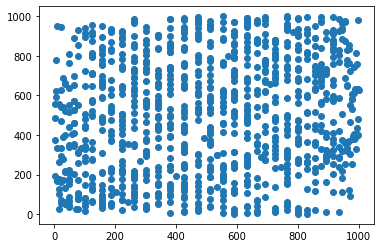

0.11228983752051397 1.5979705052240498e-07


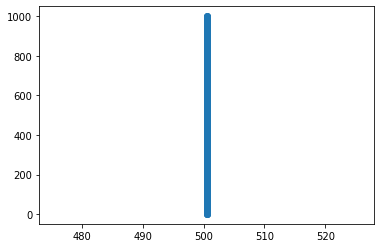

nan nan


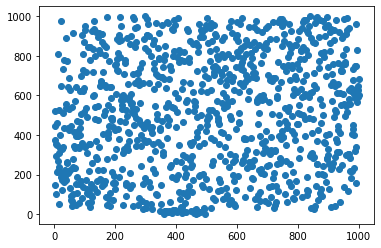

0.08829462116370974 2.9066406137722343e-05


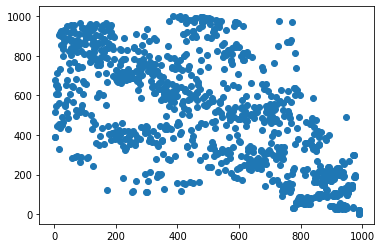

-0.46392203615695116 6.826790169279078e-107


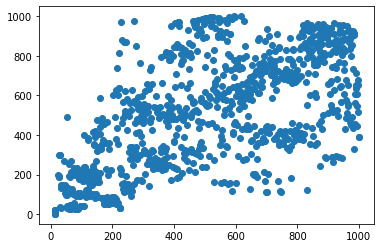

0.46392203615695116 6.826790169279078e-107


In [22]:
import matplotlib.pyplot as plt
import scipy.stats as stats

x = stats.rankdata(metric_accs)
y = stats.rankdata(api_valid_accs)
plt.scatter(x, y)
plt.show()
tau, p_value = stats.kendalltau(x, y)
print(tau, p_value)

x = stats.rankdata(metric_steps)
y = stats.rankdata(api_valid_accs)
plt.scatter(x, y)
plt.show()
tau, p_value = stats.kendalltau(x, y)
print(tau, p_value)

x = stats.rankdata(metric_confidences)
y = stats.rankdata(api_valid_accs)
plt.scatter(x, y)
plt.show()
tau, p_value = stats.kendalltau(x, y)
print(tau, p_value)

x = stats.rankdata(metric_robustnesses)
y = stats.rankdata(api_valid_accs)
plt.scatter(x, y)
plt.show()
tau, p_value = stats.kendalltau(x, y)
print(tau, p_value)

x = stats.rankdata(rank_agg)
y = stats.rankdata(api_valid_accs)
plt.scatter(x, y)
plt.show()
tau, p_value = stats.kendalltau(x, y)
print(tau, p_value)